# Comparative Performance Analysis of Language Models on Sentiment Analysis: A Case Study with Rotten Tomatoes Movie Reviews

In [24]:
# Standard Library
import logging
import pickle
import warnings
import time

# Data Processing
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.special import softmax

# HuggingFace Transformers
import datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# PyTorch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# Machine Learning Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Progress Tracking
from tqdm import tqdm

## Load Dataset

In [25]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",split=["train", "validation", "test"])
train_data, validation_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 8530
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }))

In [26]:
# Examples
print(train_data[0])
print(train_data[-1])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
{'text': 'things really get weird , though not particularly scary : the movie is all portent and no content .', 'label': 0}


In [27]:
# Convert data into pandas df form
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

In [28]:
# Switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Distribution between pos/neg reviews')

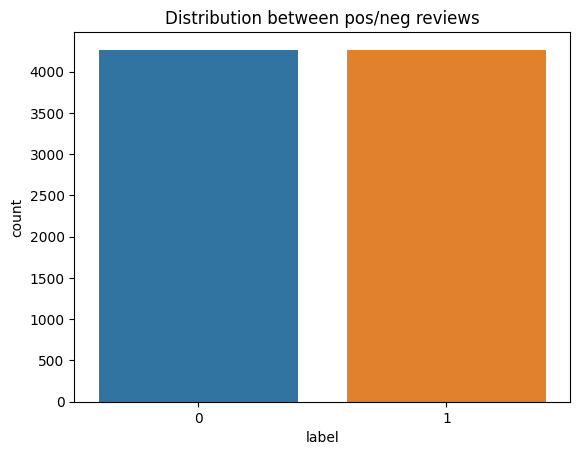

In [29]:
# Distribution between positive and negative reviews
sns.countplot(data=train_df, x='label')
plt.title("Distribution between pos/neg reviews")

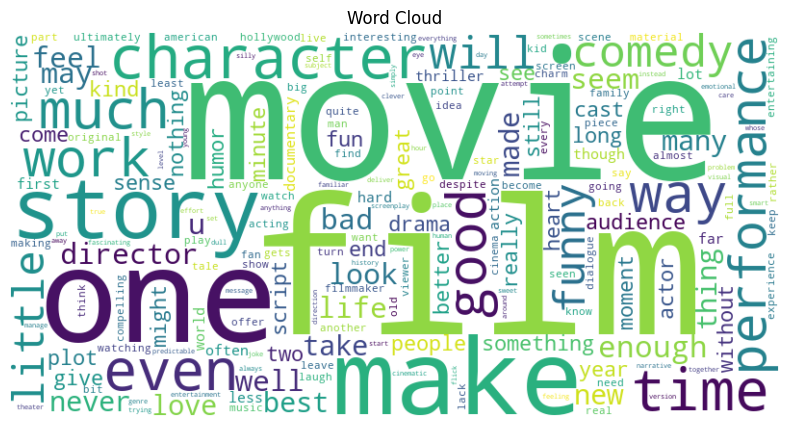

In [30]:
# Combine all text from the single column into one string
text = " ".join(train_df['text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

## NLTK Baseline
Before implementing large language models (LLMs) for sentiment analysis, it is essential to establish a baseline to evaluate their effectiveness. To achieve this, we utilize NLTK's VADER lexicon on the dataset, serving as the project's baseline model.

In [31]:
def vader_baseline(df):
    """
    Applies the VADER lexicon to perform sentiment analysis on the given dataframe and evaluates the results.
    
    The function processes the input dataframe `df`, uses the VADER lexicon for sentiment classification, 
    and evaluates the model's performance by displaying metrics, a classification report, and a confusion matrix.
    
    Args:
    - df (DataFrame): The input dataframe containing the data to be analyzed and evaluated.

    Returns:
    - results (DataFrame): The output dataframe containing the metrics of the model.
    """
    # Download VADER lexicon
    nltk.download('vader_lexicon')
    
    # Create instance of Sentiment Intensity Analyzer
    sia = SentimentIntensityAnalyzer()

    # Track test time
    start_time = time.time()
    
    # Applying polarity scores to the entire train_df
    results = {}
    for index, row in tqdm(train_df.iterrows(), total=len(df)):
        text = row['text']
        results[index] = sia.polarity_scores(text)
    
    # Convert into pandas dataframe
    vader = pd.DataFrame(results).T
    
    # Assigning predicted labels based on VADERS results
    vader_labels = {}
    for index, row in tqdm(vader.iterrows(), total=len(vader)):
        label = 1 if row['compound'] >= 0 else 0
        vader_labels[index] = label

    # Track end time
    end_time = time.time()
    duration = end_time - start_time

    # Make predictions into a column
    vader['predicted_label'] = pd.Series(vader_labels)
    vader['label'] = train_df['label']

    # Assign labels
    y_true = vader['label']
    y_pred = vader['predicted_label']
    
    # Classification metrics
    accuracy = round(accuracy_score(y_true, y_pred), 4)
    precision = round(precision_score(y_true, y_pred), 4)
    recall = round(recall_score(y_true, y_pred), 4)
    f1 = round(f1_score(y_true, y_pred), 4)
    roc_auc = round(roc_auc_score(y_true, y_pred), 4)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC Score: {roc_auc}")
    print("Classification Report:\n", report)
    
    # Confusion matrix
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

    # Output
    output = pd.DataFrame({"model": "Vader",
                          "accuracy": [accuracy],
                          "precision": [precision],
                          "recall": [recall],
                          "f1 score": [f1],
                          "roc-auc score": [roc_auc],
                          "duration": [duration]})

    return output


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


8530it [00:02, 3513.09it/s]                         
100%|██████████| 8530/8530 [00:00<00:00, 34871.11it/s]


Accuracy: 0.61
Precision: 0.5771
Recall: 0.823
F1 Score: 0.6785
ROC-AUC Score: 0.61
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.40      0.50      4265
           1       0.58      0.82      0.68      4265

    accuracy                           0.61      8530
   macro avg       0.63      0.61      0.59      8530
weighted avg       0.63      0.61      0.59      8530



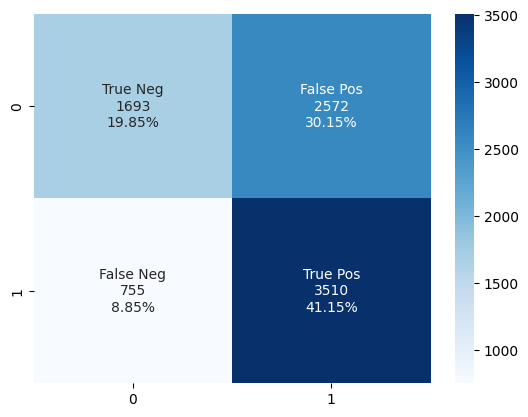

In [32]:
# Run vader
vader_results = vader_baseline(test_df)

## Pipeline for Pre-Trained Models

In [33]:
def tokenize_texts(text, tokenizer, model):
    """
    Tokenizes a given text, processes it using the specified model, and returns the softmax scores.

    Args:
    - text (str): A single sentence from a movie review to be analyzed.
    - tokenizer: The tokenizer object used to convert the input text into tokens compatible with the model.
    - model: The language model (LLM) used to process the tokenized input and generate output scores.

    Returns:
    - scores (ndarray): The softmax probabilities of the model's output for the tokenized text.
    """
    encoded_text = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_text)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    return scores

In [34]:
# Polarity scores for pre-tuned BERT-based models
def polarity_score(text, tokenizer, model):
    """
    Compute polarity scores using a pre-tuned BERT-based model for sentiment analysis. 
    The sentiment categories are: ['negative', 'positive'].

    Args:
    - text (str): A single sentence from a movie review to be analyzed.
    - tokenizer: The tokenizer object used to convert the input text into tokens compatible with the model.
    - model: The language model (LLM) used to process the tokenized input and generate sentiment scores.

    Returns:
    - scores_dict (dict): A dictionary containing the probabilities for each sentiment category, with keys:
        - 'neg_score': Probability of the text being negative.
        - 'pos_score': Probability of the text being positive.
    """
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[0],
        'pos_score' : scores[1]
    }
    return scores_dict

# Polarity scores for fine-tuned RoBERTa
def roberta_tuned_polarity_score(text, tokenizer, model):
    """
    Compute polarity scores using a fine-tuned RoBERTa model for sentiment analysis.
    The model initially outputs three sentiment scores: negative, neutral, and positive. 
    These scores are transformed into two categories: ['negative', 'positive'], by redistributing the neutral score equally.

    Args:
    - text (str): A single sentence from a movie review to be analyzed.
    - tokenizer: The tokenizer object used to convert the input text into tokens compatible with the model.
    - model: The fine-tuned RoBERTa language model (LLM) used to process the tokenized input and generate sentiment scores.

    Returns:
    - scores_dict (dict): A dictionary containing the probabilities for each sentiment category, with keys:
        - 'neg_score': Probability of the text being negative, derived from the negative score and half of the neutral score.
        - 'pos_score': Probability of the text being positive, derived from the positive score and half of the neutral score.
    """
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[0] + (scores[1]/2),
        'pos_score' : scores[2] + (scores[1]/2)
    }
    return scores_dict

# Polarity scores for fine-tuned DistilBERT
def distilbert_tuned_polarity_score(text, tokenizer, model):
    """
    Compute polarity scores using a fine-tuned DistilBERT model for sentiment analysis.
    The model initially outputs three sentiment scores: negative, neutral, and positive. 
    These scores are transformed into two categories: ['negative', 'positive'], by redistributing the neutral score equally.

    Args:
    - text (str): A single sentence from a movie review to be analyzed.
    - tokenizer: The tokenizer object used to convert the input text into tokens compatible with the model.
    - model: The fine-tuned DistilBERT language model (LLM) used to process the tokenized input and generate sentiment scores.

    Returns:
    - scores_dict (dict): A dictionary containing the probabilities for each sentiment category, with keys:
        - 'neg_score': Probability of the text being negative, derived from the negative score and half of the neutral score.
        - 'pos_score': Probability of the text being positive, derived from the positive score and half of the neutral score.
    """
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[2] + (scores[1]/2),
        'pos_score' : scores[0] + (scores[1]/2)
    }
    return scores_dict

# Polarity scores for fine-tuned BERT
def bert_tuned_polarity_score(text, tokenizer, model):
    """
    Compute polarity scores using a fine-tuned BERT model for sentiment analysis.
    The model outputs five sentiment scores (1, 2, 3, 4, 5), representing a spectrum of sentiments.
    These scores are transformed into two categories: ['negative', 'positive'], by redistributing the middle score (3) equally between the two categories.

    Args:
    - text (str): A single sentence from a movie review to be analyzed.
    - tokenizer: The tokenizer object used to convert the input text into tokens compatible with the model.
    - model: The fine-tuned BERT language model (LLM) used to process the tokenized input and generate sentiment scores.

    Returns:
    - scores_dict (dict): A dictionary containing the probabilities for each sentiment category:
        - 'neg_score': Combined probability of the text being negative, derived from the scores for 1, 2, and half of 3.
        - 'pos_score': Combined probability of the text being positive, derived from the scores for 4, 5, and half of 3.
    """
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[0] + scores[1] + (scores[2]/2),
        'pos_score' : scores[3] + scores[4] + (scores[2]/2)
    }
    return scores_dict

In [35]:
def sentiment_classifier(model, tokenizer, dataset, name):
    """
    Generate polarity scores and predictions for each text in the dataset using the specified model and tokenizer.
    The function applies different pre-tuned sentiment analysis methods based on the provided `name`, which can be 
    'roberta_tuned', 'distilbert_tuned', 'bert_tuned', or others.

    Args:
    - model: Pre-trained or fine-tuned language model (LLM) used for sentiment analysis.
    - tokenizer: Tokenizer corresponding to the model, used to process input text.
    - dataset (DataFrame): DataFrame containing the text data for which predictions are to be made.
    - name (str): Specifies the model type to apply ('roberta_tuned', 'distilbert_tuned', 'bert_tuned', or others).

    Returns:
    - results (DataFrame): A DataFrame containing the polarity scores and predicted labels for each input text.
    """
    # Running the model on the entire train_df dataset
    res = {}
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        try:
            text = row['text']
            if name == 'roberta_tuned':
                res[index] = roberta_tuned_polarity_score(text, tokenizer, model)
            elif name == 'distilbert_tuned':
                res[index] = distilbert_tuned_polarity_score(text, tokenizer, model)
            elif name == 'bert_tuned':
                res[index] = bert_tuned_polarity_score(text, tokenizer, model)
            else:
                res[index] = polarity_score(text, tokenizer, model)
        except RuntimeError:
            print(f'Broke for id {index}')

    # Displaying the result in a dataframe format
    results = pd.DataFrame(res).T

    # Convert model outputs into binary classification
    labels = {}
    num_of_cols = len(results.columns)
    for index,row in results.iterrows():
        label = 1 if row['pos_score'] >= row['neg_score'] else 0
        labels[index] = label

    # Add predicted labels columns into results
    results['predicted_labels'] = pd.Series(labels)

    return results

In [36]:
def get_model_results(model, dataset, name):
    """
    Load the tokenizer and model, then call the `sentiment_classifier` function to predict sentiment results 
    for the input dataset.

    Args:
    - model (str): Pre-trained or fine-tuned language model (LLM) used for sentiment analysis.
    - dataset (DataFrame): DataFrame containing the text data for which predictions are to be made.
    - name (str): Specifies the model type to apply ('roberta_tuned', 'distilbert_tuned', 'bert_tuned', or others).

    Returns:
    - results (DataFrame): A DataFrame containing the polarity scores and predicted labels for each input text.
    """
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model, return_tensors='pt',truncation=True, max_length=256, padding=True)
    output_model = AutoModelForSequenceClassification.from_pretrained(model)
    output_model = output_model.to(device)
    results = sentiment_classifier(output_model, tokenizer, dataset, name)
    end_time = time.time()
    duration = end_time - start_time

    return results, duration

In [39]:
# Suppress warnings for this code block only
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
warnings.filterwarnings(action='ignore', category=FutureWarning, 
                        message=r".*`clean_up_tokenization_spaces` was not set.*")

# Pre-tuned RoBERTa
model = "FacebookAI/roberta-base"
roberta_results, roberta_duration = get_model_results(model=model, dataset=test_df, name='roberta')

# Fine-tuned RoBERTa on Twitter
model = "cardiffnlp/twitter-roberta-base-sentiment"
roberta_tuned_results, roberta_tuned_duration = get_model_results(model=model, dataset=test_df, name='roberta_tuned')

# Pre-tune DistilBERT
model = "distilbert-base-uncased"
distilbert_results, distilbert_duration = get_model_results(model=model, dataset=test_df, name='distilbert')

# Fine-tuned DistilBERT
model = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
distilbert_tuned_results, distilbert_tuned_duration = get_model_results(model=model, dataset=test_df, name='distilbert_tuned')

# Pre-tuned BERT
model = "bert-base-uncased"
bert_results, bert_duration = get_model_results(model=model, dataset=test_df, name='bert')

# Fine-tuned BERT
model = "nlptown/bert-base-multilingual-uncased-sentiment"
bert_tuned_results, bert_tuned_duration = get_model_results(model=model, dataset=test_df, name='bert_tuned')

# Reinstate warnings
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)

100%|██████████| 1066/1066 [00:11<00:00, 91.62it/s]


In [40]:
# Models and their respective results
model_results = {
    "RoBERTa": roberta_results['predicted_labels'],
    "Fine-tuned RoBERTa": roberta_tuned_results['predicted_labels'],
    "DistilBERT": distilbert_results['predicted_labels'],
    "Fine-tuned DistilBERT": distilbert_tuned_results['predicted_labels'],
    "BERT": bert_results['predicted_labels'],
    "Fine-tuned BERT": bert_tuned_results['predicted_labels']
}

# Initialize metrics dictionary
metrics = {
    "accuracy": accuracy_score,
    "precision": lambda y, y_pred: precision_score(y, y_pred, zero_division=0.0),
    "recall": recall_score,
    "f1 score": f1_score,
    "roc-auc score": roc_auc_score
}

# Compute metrics for each model
results = []
for model_name, predictions in model_results.items():
    model_metrics = {metric_name: round(metric_func(test_df['label'], predictions), 4)
                     for metric_name, metric_func in metrics.items()}
    model_metrics['model'] = model_name
    results.append(model_metrics)

# Convert to DataFrame
pre_tuned_results = pd.DataFrame(results)

# Add durations
pre_tuned_results['duration'] = [roberta_duration, roberta_tuned_duration,
                                distilbert_duration, distilbert_tuned_duration,
                                bert_duration, bert_tuned_duration]

# Format
pre_tuned_results.insert(0, "model", pre_tuned_results.pop("model"))

# Display the results
pre_tuned_results

,model,accuracy,precision,recall,f1 score,roc-auc score,duration
0,RoBERTa,0.5000,0.0000,0.0000,0.0000,0.5000,12.419727
1,Fine-tuned RoBERTa,0.7871,0.8148,0.7430,0.7772,0.7871,12.579784
2,DistilBERT,0.4906,0.4951,0.9568,0.6526,0.4906,8.350171
3,Fine-tuned DistilBERT,0.6445,0.6851,0.5347,0.6006,0.6445,8.634897
4,BERT,0.4925,0.3333,0.0150,0.0287,0.4925,11.937287
5,Fine-tuned BERT,0.7749,0.7504,0.8236,0.7853,0.7749,13.202971


## Prepare Data for LLMs

In [41]:
class SentimentDataset(Dataset):
    """
    A custom PyTorch Dataset class for handling sentiment analysis data, including text preprocessing and tokenization.

    Attributes:
    - texts (list of str): A list of text samples for sentiment analysis.
    - labels (list of int): A list of corresponding sentiment labels for each text sample.
    - tokenizer (Tokenizer): A tokenizer object used to tokenize the text samples.
    - max_length (int): The maximum length for tokenized sequences. Longer sequences will be truncated, and shorter ones will be padded.

    Methods:
    - __len__(): Returns the total number of samples in the dataset.
    - __getitem__(idx): Retrieves the tokenized input IDs, attention mask, and label for a sample at the given index.
    """

    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Initializes the SentimentDataset instance with text data, labels, tokenizer, and a specified maximum token length.
    
        Args:
        - texts (list of str): A list of text samples for sentiment analysis.
        - labels (list of int): A list of corresponding sentiment labels for each text sample.
        - tokenizer (Tokenizer): A tokenizer object used to tokenize the text samples.
        - max_length (int): The maximum length for tokenized sequences. Longer sequences will be truncated, and shorter ones will be padded.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
    
        Returns:
        - int: The number of text samples in the dataset.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single tokenized sample from the dataset at the specified index.
    
        Args:
        - idx (int): The index of the sample to retrieve.
    
        Returns:
        - dict: A dictionary containing the following keys:
            - 'input_ids' (torch.Tensor): Tokenized input IDs for the text, padded/truncated to max_length.
            - 'attention_mask' (torch.Tensor): Attention mask for the input, indicating padding positions.
            - 'label' (torch.Tensor): The sentiment label for the text sample, converted to a PyTorch tensor of type long.
        """
        text = self.texts[idx]
        label = self.labels[idx]
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            return_token_type_ids=False,  # Set to False because we're only doing sentiment analysis
            padding='max_length',         # Pad to max_length for consistent token length
            truncation=True,              # Truncate to max_length for consisten token length
            return_tensors="pt"           # Return tensors in PyTorch format
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [42]:
def data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size):
    """
    Prepares the data for training, validation, and testing by creating datasets and data loaders.

    Args:
    - train_df (DataFrame): DataFrame containing the training data with columns 'text' and 'label'.
    - val_df (DataFrame): DataFrame containing the validation data with columns 'text' and 'label'.
    - test_df (DataFrame): DataFrame containing the testing data with columns 'text' and 'label'.
    - tokenizer (Tokenizer): Tokenizer object to tokenize the text data.
    - max_length (int): Maximum token length for padding or truncating text sequences.
    - batch_size (int): Batch size to be used for the data loaders.

    Returns:
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - test_loader (DataLoader): DataLoader for the testing dataset.
    """
    # Assign texts and labels
    train_texts = train_df['text']
    train_labels = train_df['label']
    val_texts = val_df['text']
    val_labels = val_df['label']
    test_texts = test_df['text']
    test_labels = test_df['label']
    
    # Datasets
    dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length=max_length)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length=max_length)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_length=max_length)
    
    # DataLoader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Create Sentiment Classifier

In [43]:
class SentimentClassifier(nn.Module):
    """
    A neural network model for sentiment classification based on a pre-trained transformer. 
    This model uses hidden states from the transformer, applies dropout for regularization, 
    and a fully connected layer to map the output to the desired number of sentiment classes.

    Attributes:
    - model (transformers.PreTrainedModel): The pre-trained transformer model used for extracting hidden states.
    - dropout (nn.Dropout): Dropout layer to reduce overfitting.
    - fc (nn.Linear): Fully connected layer to project the transformer outputs to the desired number of classes.
    """

    def __init__(self, n_classes, model):
        """
        Initializes the SentimentClassifier model.

        Args:
        - n_classes (int): The number of classes for the output (e.g., binary classification: 2).
        - model (transformers.PreTrainedModel): A pre-trained transformer model that provides hidden states.
        """
        super(SentimentClassifier, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.3)                                 # Dropout to reduce overfitting
        self.fc = nn.Linear(self.model.config.hidden_size, n_classes)  # Fully-connected layer to convert output into binary

    def forward(self, input_ids, attention_mask):
        """
        Defines the forward pass of the SentimentClassifier model.

        Args:
        - input_ids (torch.Tensor): Tensor of tokenized input sequences of shape (batch_size, sequence_length).
        - attention_mask (torch.Tensor): Tensor indicating the attention mask of shape (batch_size, sequence_length).

        Returns:
        - output (torch.Tensor): The logits of shape (batch_size, n_classes), representing unnormalized scores for each class.
        """
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        second_to_last_layer = hidden_states[-2]   # Extract second-to-last layer (last layer is too closed to the target functions)
        cls_token = second_to_last_layer[:, 0, :]  # Pool the CLS token
        output = self.dropout(cls_token)

        return self.fc(output)

## Train and Validate Model

In [44]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, history):
    """
    Train a sentiment classification model.

    Args:
    - model (SentimentClassifier): The sentiment classification model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset (required for history).
    - optimizer (torch.optim.Optimizer): Optimizer used to update model parameters.
    - loss_fn (Callable): Loss function used to calculate the prediction error.
    - device (torch.device): The device (CPU or GPU) on which computations are performed.
    - history (dict): Dictionary to store the training and validation loss/metrics over epochs.

    Returns:
    - history (dict): Updated dictionary containing the training and validation loss/metrics.
    """
    # Training Phase
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    train_batches = len(train_loader)

    # Live tracking using tqdm
    pbar = tqdm(train_loader, desc="Training", leave=False)

    # Train data in batches
    for batch_idx, batch in enumerate(pbar):

        # Move inputs and labels to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Reset gradients on each epoch
        optimizer.zero_grad()

        # Model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Keep track of training losses
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Model predictions using argmax
        preds = torch.argmax(outputs, dim=1)

        # Compute running accuracy
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        running_accuracy = train_correct / train_total
        running_loss = train_loss / (batch_idx + 1)

        # Update progress bar description
        pbar.set_description(f"Training: Loss {running_loss:.4f} | Acc {running_accuracy:.4f}")

        # Update gradients
        loss.backward()
        optimizer.step()

    # Epoch-level metrics
    epoch_train_loss = train_loss / train_batches
    epoch_train_accuracy = train_correct / train_total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_accuracy)

    # Print epoch metrics
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

    return history

In [45]:
def evaluate_model(model, val_loader, loss_fn, device, history):
    """
    Evaluate a sentiment classification model.

    Args:
    - model (SentimentClassifier): The trained sentiment classification model to be evaluated.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - loss_fn (Callable): Loss function used to calculate the prediction error.
    - device (torch.device): The device (CPU or GPU) on which computations are performed.
    - history (dict): Dictionary to store the training and validation loss/metrics over epochs.

    Returns:
    - history (dict): Updated dictionary containing the training and validation loss/metrics.
    """
    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_batches = len(val_loader)

    # Run without updating gradients
    with torch.no_grad():

        # Evaluate model in batches
        for batch in tqdm(val_loader, desc="Validation", leave=False):

            # Move inputs to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Track validation losses
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Model predictions using argmax
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate metrics
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Epoch-level metrics
    epoch_val_loss = val_loss / val_batches
    epoch_val_accuracy = val_correct / val_total
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_accuracy)

    # Print epoch metrics
    print(f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    return history

In [46]:
# Train and evaluate model per epoch
def train_and_evaluate_model(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, history):
    """
    Centralize the training and evaluating phases of the sentiment classifier model.

    Args:
    - model (SentimentClassifier): The sentiment classification model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - optimizer (torch.optim.Optimizer): Optimizer used to update model parameters.
    - loss_fn (Callable): Loss function used to calculate the prediction error.
    - epochs (int): Number of epochs to train and evaluate the model on.
    - device (torch.device): The device (CPU or GPU) on which computations are performed.
    - history (dict): Dictionary to store the training and validation loss/metrics over epochs.

    Returns:
    - history (dict): Updated dictionary containing the training and validation loss/metrics.
    """
    # Move model to GPU
    model.to(device)

    # Monitor train time
    total_time = 0
    train_time = []

    # Train and evaluate model
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        torch.cuda.synchronize()
        start_epoch = time.time()
        history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, history)
        end_epoch = time.time()
        epoch_duration = end_epoch - start_epoch
        total_time = total_time + epoch_duration
        train_time.append(total_time)
        history = evaluate_model(model, val_loader, loss_fn, device, history)

    return history, train_time

## Plot Metrics

In [47]:
def plot_metrics(history):
    """
    Plot training and validation metrics over epochs.

    Args:
    - history (dict): A dictionary containing training and validation metrics
      with keys 'train_loss', 'val_loss', 'train_accuracy', and 'val_accuracy'.
      Each key's value is a list representing the metric values for each epoch.
    """
    # Get number of epochs
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display plot
    plt.show()

## Run Pipeline

In [48]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup
max_length = 256
batch_size = 64
num_of_epochs = 5
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# History
roberta_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
distilbert_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
bert_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Suppress warnings for training models phase
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

### RoBERTa

Epoch 1/5


Train Loss: 0.6009, Train Accuracy: 0.6510


Val Loss: 0.3119, Val Accuracy: 0.8649
Epoch 2/5


Train Loss: 0.3406, Train Accuracy: 0.8645


Val Loss: 0.3018, Val Accuracy: 0.8818
Epoch 3/5


Train Loss: 0.3167, Train Accuracy: 0.8730


Val Loss: 0.3204, Val Accuracy: 0.8734
Epoch 4/5


Train Loss: 0.2854, Train Accuracy: 0.8859


Val Loss: 0.2932, Val Accuracy: 0.8780
Epoch 5/5


Train Loss: 0.2789, Train Accuracy: 0.8872


Val Loss: 0.3301, Val Accuracy: 0.8630


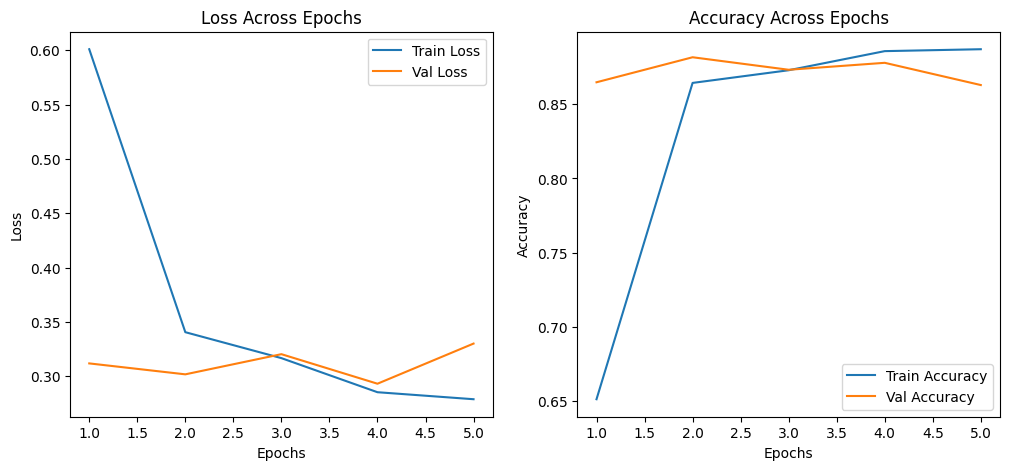

In [49]:
# Tokenize and load data
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
train_loader, val_loader, test_loader = data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size)

# Instantiate model
roberta_model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base", output_hidden_states=True)
roberta_model = SentimentClassifier(n_classes=2, model=roberta_model)
roberta_model = roberta_model.to(device)

# Optimizer
optimizer = torch.optim.Adam(roberta_model.parameters(), lr=2e-5, weight_decay=0.1)

# Train and evaluate model
roberta_history, roberta_train_time = train_and_evaluate_model(roberta_model, train_loader, val_loader,
                                                               optimizer, loss_fn, num_of_epochs, device, roberta_history)

# Plot metrics
plot_metrics(roberta_history)

### DistilBERT

Epoch 1/5


Train Loss: 0.6924, Train Accuracy: 0.5433


Val Loss: 0.6163, Val Accuracy: 0.7045
Epoch 2/5


Train Loss: 0.5244, Train Accuracy: 0.7440


Val Loss: 0.4308, Val Accuracy: 0.8011
Epoch 3/5


Train Loss: 0.4317, Train Accuracy: 0.8015


Val Loss: 0.4021, Val Accuracy: 0.8114
Epoch 4/5


Train Loss: 0.4102, Train Accuracy: 0.8134


Val Loss: 0.3916, Val Accuracy: 0.8143
Epoch 5/5


Train Loss: 0.4002, Train Accuracy: 0.8169


Val Loss: 0.3871, Val Accuracy: 0.8208


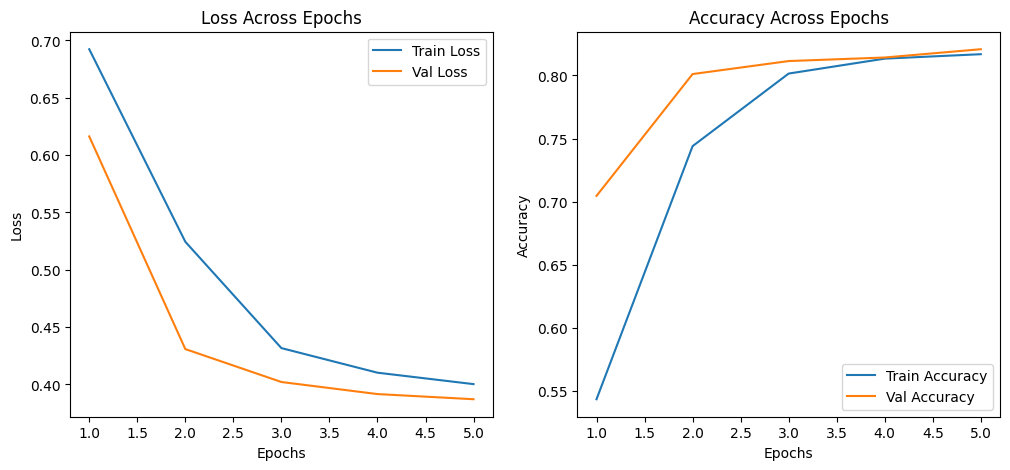

In [50]:
# Tokenize and load data
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_loader, val_loader, test_loader = data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size)

# Instantiate model
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
distilbert_model = SentimentClassifier(n_classes=2, model=distilbert_model)
distilbert_model = distilbert_model.to(device)

# Optimizer
optimizer = torch.optim.Adam(distilbert_model.parameters(), lr=2e-5, weight_decay=0.1)

# Train and evaluate model
distilbert_history, distilbert_train_time = train_and_evaluate_model(distilbert_model, train_loader, val_loader,
                                                                     optimizer, loss_fn, num_of_epochs, device, distilbert_history)

# Plot metrics
plot_metrics(distilbert_history)

### BERT

Epoch 1/5


Train Loss: 0.6467, Train Accuracy: 0.6229


Val Loss: 0.4692, Val Accuracy: 0.7983
Epoch 2/5


Train Loss: 0.4076, Train Accuracy: 0.8217


Val Loss: 0.3827, Val Accuracy: 0.8189
Epoch 3/5


Train Loss: 0.3711, Train Accuracy: 0.8360


Val Loss: 0.4309, Val Accuracy: 0.8030
Epoch 4/5


Train Loss: 0.3537, Train Accuracy: 0.8477


Val Loss: 0.3459, Val Accuracy: 0.8508
Epoch 5/5


Train Loss: 0.3564, Train Accuracy: 0.8419


Val Loss: 0.3565, Val Accuracy: 0.8349


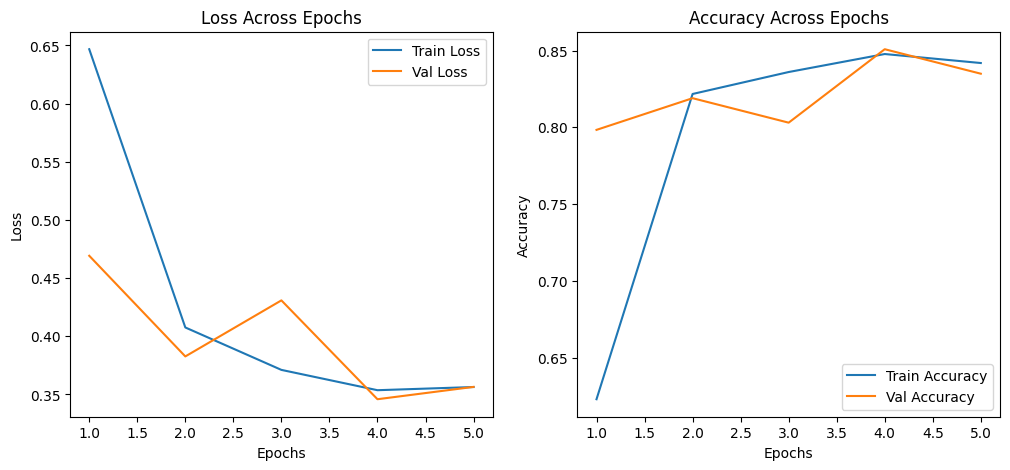

In [51]:
# Tokenize and load data
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_loader, val_loader, test_loader = data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size)

# Instantiate model
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_model = SentimentClassifier(n_classes=2, model=bert_model)
bert_model = bert_model.to(device)

# Optimizer
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5, weight_decay=0.1)

# Train and evaluate model
bert_history, bert_train_time = train_and_evaluate_model(bert_model, train_loader, val_loader,
                                                         optimizer, loss_fn, num_of_epochs, device, bert_history)

# Plot metrics
plot_metrics(bert_history)

In [52]:
# Reset warnings
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)

# Testing

In [53]:
def test_model(model, dataloader):
    """
    Evaluate a trained model on a test dataset and return predictions.

    Args:
    - model (SentimentClassifier): The trained sentiment classifier model to be evaluated.
    - dataloader (DataLoader): DataLoader object containing the test dataset.

    Returns:
    - predictions (list): A list of predicted labels for the test dataset.
    """
    # Set model to evaluate
    model.eval()
    predictions = []
    start_time = time.time()

    # Run without updating gradients
    with torch.no_grad():

        # Test in batches
        for batch in dataloader:

            # Move inputs to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Model predictions using argmax
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    end_time = time.time()
    duration = end_time - start_time

    return predictions, duration

In [54]:
# Test the models
roberta_predictions, roberta_test_time = test_model(roberta_model, test_loader)
distilbert_predictions, distilbert_test_time = test_model(distilbert_model, test_loader)
bert_predictions, bert_test_time = test_model(bert_model, test_loader)

# Model Comparison

In [55]:
# Get true values
y_true = test_df['label']

# Define models and their corresponding predictions
models = {
    "RoBERTa": roberta_predictions,
    "DistilBERT": distilbert_predictions,
    "BERT": bert_predictions
}

# Initialize results dictionary
results = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
    "roc-auc score": []
}

# Calculate metrics for each model
for model_name, predictions in models.items():
    results["model"].append(model_name)
    results["accuracy"].append(round(accuracy_score(y_true, predictions), 4))
    results["precision"].append(round(precision_score(y_true, predictions), 4))
    results["recall"].append(round(recall_score(y_true, predictions), 4))
    results["f1 score"].append(round(f1_score(y_true, predictions), 4))
    results["roc-auc score"].append(round(roc_auc_score(y_true, predictions), 4))

# Add durations
results["duration"] = [roberta_duration, distilbert_duration, bert_duration]

# Convert results to a DataFrame
final_results = pd.DataFrame(results)

# Display
final_results

,model,accuracy,precision,recall,f1 score,roc-auc score,duration
0,RoBERTa,0.5197,0.5235,0.4390,0.4776,0.5197,12.419727
1,DistilBERT,0.8171,0.8536,0.7655,0.8071,0.8171,8.350171
2,BERT,0.8321,0.8417,0.8180,0.8297,0.8321,11.937287


In [73]:
# Concat all results
results = pd.concat([vader_results,final_results,pre_tuned_results]).reset_index(drop=True)

# Rename model names
results.loc[0, 'model'] = 'VADER'
results.loc[1, 'model'] = 'Fine-tuned RoBERTa (Rotten Tomatoes)'
results.loc[2, 'model'] = 'Fine-tuned DistilBERT (Rotten Tomatoes)'
results.loc[3, 'model'] = 'Fine-tuned BERT (Rotten Tomatoes)'
results.loc[4, 'model'] = 'Pre-tuned RoBERTa'
results.loc[5, 'model'] = 'Fine-tuned RoBERTa (Twitter)'
results.loc[6, 'model'] = 'Pre-tuned DistilBERT'
results.loc[7, 'model'] = 'Fine-tuned DistilBERT (multilingual sentiment)'
results.loc[8, 'model'] = 'Pre-tuned BERT'
results.loc[9, 'model'] = 'Fine-tuned BERT (multilingual sentiment)'

# Reposition rows
results = results.reindex(index=[0,4,5,1,6,7,2,8,9,3])
results = results.reset_index(drop=True)

# Display results
results

,model,accuracy,precision,recall,f1 score,roc-auc score,duration
0,VADER,0.6100,0.5771,0.8230,0.6785,0.6100,2.823124
1,Pre-tuned RoBERTa,0.5000,0.0000,0.0000,0.0000,0.5000,12.419727
2,Fine-tuned RoBERTa (Twitter),0.7871,0.8148,0.7430,0.7772,0.7871,12.579784
3,Fine-tuned RoBERTa (Rotten Tomatoes),0.5197,0.5235,0.4390,0.4776,0.5197,12.419727
4,Pre-tuned DistilBERT,0.4906,0.4951,0.9568,0.6526,0.4906,8.350171
5,Fine-tuned DistilBERT (multilingual sentiment),0.6445,0.6851,0.5347,0.6006,0.6445,8.634897
6,Fine-tuned DistilBERT (Rotten Tomatoes),0.8171,0.8536,0.7655,0.8071,0.8171,8.350171
7,Pre-tuned BERT,0.4925,0.3333,0.0150,0.0287,0.4925,11.937287
8,Fine-tuned BERT (multilingual sentiment),0.7749,0.7504,0.8236,0.7853,0.7749,13.202971
9,Fine-tuned BERT (Rotten Tomatoes),0.8321,0.8417,0.8180,0.8297,0.8321,11.937287


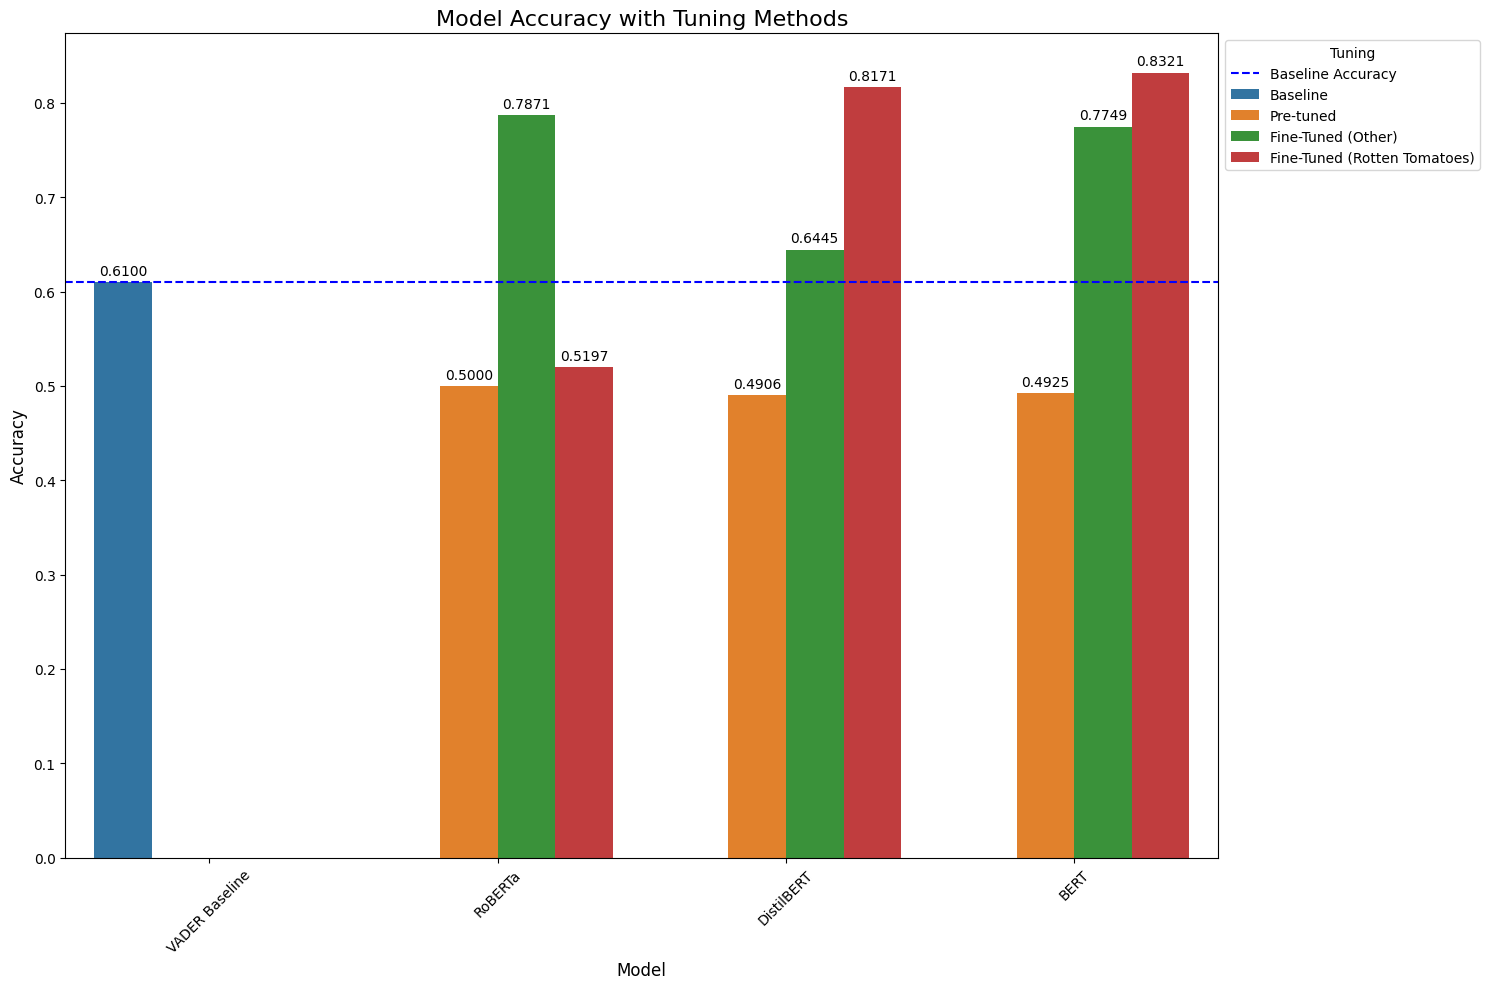

In [130]:
# Data Preparation
results_accuracy = list(results['accuracy'])
results_simplified = pd.DataFrame({
    'model': ['VADER Baseline',
              'RoBERTa', 'RoBERTa', 'RoBERTa',
              'DistilBERT', 'DistilBERT', 'DistilBERT',
              'BERT', 'BERT', 'BERT'],
    'accuracy': results_accuracy,
    'tuning': ['Baseline',
               'Pre-tuned', 'Fine-Tuned (Other)', 'Fine-Tuned (Rotten Tomatoes)',
               'Pre-tuned', 'Fine-Tuned (Other)', 'Fine-Tuned (Rotten Tomatoes)',
               'Pre-tuned', 'Fine-Tuned (Other)', 'Fine-Tuned (Rotten Tomatoes)']
})

# Plotting
plt.figure(figsize=(15, 10))

# Create the grouped bar plot
ax = sns.barplot(data=results_simplified, x='model', y='accuracy', hue='tuning', palette='tab10')

# Add a horizontal line for the baseline
baseline_value = results_simplified.iloc[0]['accuracy']
plt.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=1.5, label='Baseline Accuracy')

# Add accuracy labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', fontsize=10, padding=3)

# Customize the plot
plt.title('Model Accuracy with Tuning Methods', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)  # Align text for better readability
plt.legend(title='Tuning', loc='upper left', bbox_to_anchor=(1, 1))

# Finalize layout
plt.tight_layout()

# Show the plot
plt.show()


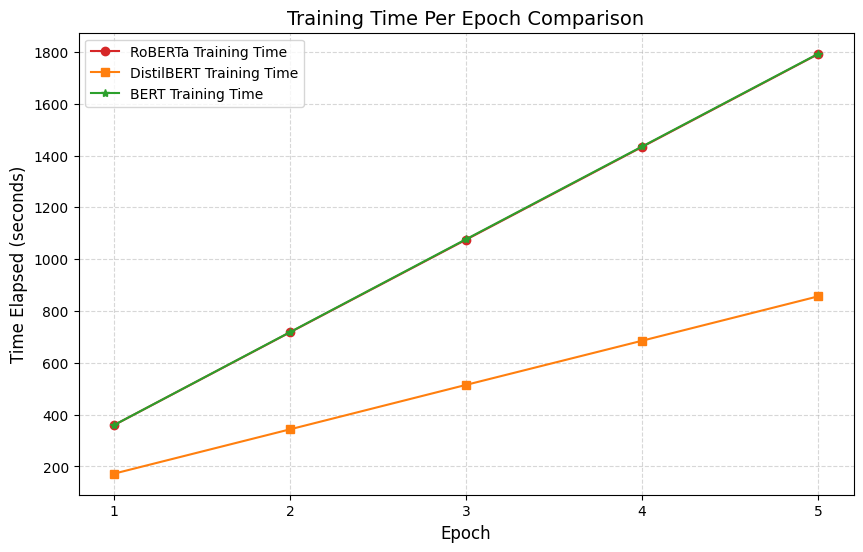

In [121]:
# Create an epoch range
epochs = range(1, 6)

# Plot the times
plt.figure(figsize=(10, 6))
plt.plot(epochs, roberta_train_time, label='RoBERTa Training Time', marker='o', color='tab:red')
plt.plot(epochs, distilbert_train_time, label='DistilBERT Training Time', marker='s', color='tab:orange')
plt.plot(epochs, bert_train_time, label='BERT Training Time', marker='*', color='tab:green')

# Add title and labels
plt.title('Training Time Per Epoch Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Time Elapsed (seconds)', fontsize=12)

# Only display whole numbers
plt.xticks(epochs)

# Add legend
plt.legend(fontsize=10)

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()


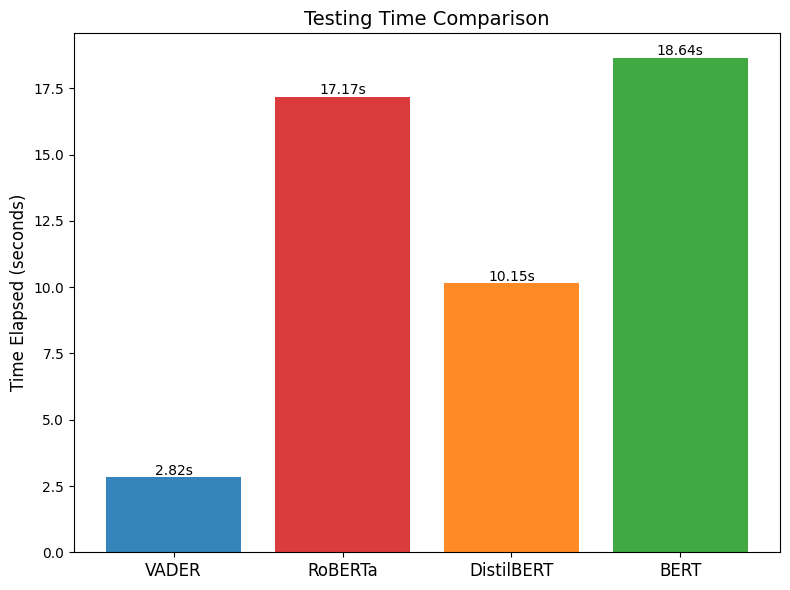

In [129]:
# Data
vader_duration = vader_results['duration'][0]
data = [vader_duration, roberta_test_time, distilbert_test_time, bert_test_time]
x_labels = ['VADER', 'RoBERTa', 'DistilBERT', 'BERT']
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(data)), data, color=colors, alpha=0.9)

# Add labels and title
plt.xticks(range(len(data)), x_labels, fontsize=12)  # Set x-axis labels
plt.ylabel('Time Elapsed (seconds)', fontsize=12)
plt.title('Testing Time Comparison', fontsize=14)

# Add value labels on top of the bars
for i, value in enumerate(data):
    plt.text(i, value + 0.1, f'{value:.2f}s', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


## Save Models

In [131]:
pickle.dump(model, open('roberta_model.sav', 'wb'))
pickle.dump(model, open('distilbert_model.sav', 'wb'))
pickle.dump(model, open('bert_model.sav', 'wb'))